#Initializing Spark

In [4]:
!pip3 -q install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Spark_Pipeline').master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


<SparkContext master=local[*] appName=Spark_Pipeline>

##Libraries

In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from pyspark.sql.functions import mean
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,NaiveBayes

#DATA

##Load Data

In [6]:
!wget -q 'https://raw.githubusercontent.com/soumyob-praxis/Spark-BrainStroke/main/brain_stroke.csv'  ##https://github.com/soumyob-praxis/Spark-BrainStroke

In [7]:
#loading dataset into spark dataframe
df = spark.read.csv('/content/brain_stroke.csv', inferSchema=True,header=True)
df.show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

##Basic EDA

In [8]:
df.count()

4981

In [9]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [10]:
df.describe().show()

+-------+------+-----------------+-------------------+--------------------+------------+---------+--------------+------------------+------------------+--------------+--------------------+
|summary|gender|              age|       hypertension|       heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|              stroke|
+-------+------+-----------------+-------------------+--------------------+------------+---------+--------------+------------------+------------------+--------------+--------------------+
|  count|  4981|             4981|               4981|                4981|        4981|     4981|          4981|              4981|              4981|          4981|                4981|
|   mean|  null| 43.4198594659707|0.09616542862878939|0.055209797229471995|        null|     null|          null|105.94356153382824|28.498173057619002|          null|0.049789198956032926|
| stddev|  null|22.66275507369848|0.29484757470019735|  0.22

In [11]:
df.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  248|
|     0| 4733|
+------+-----+



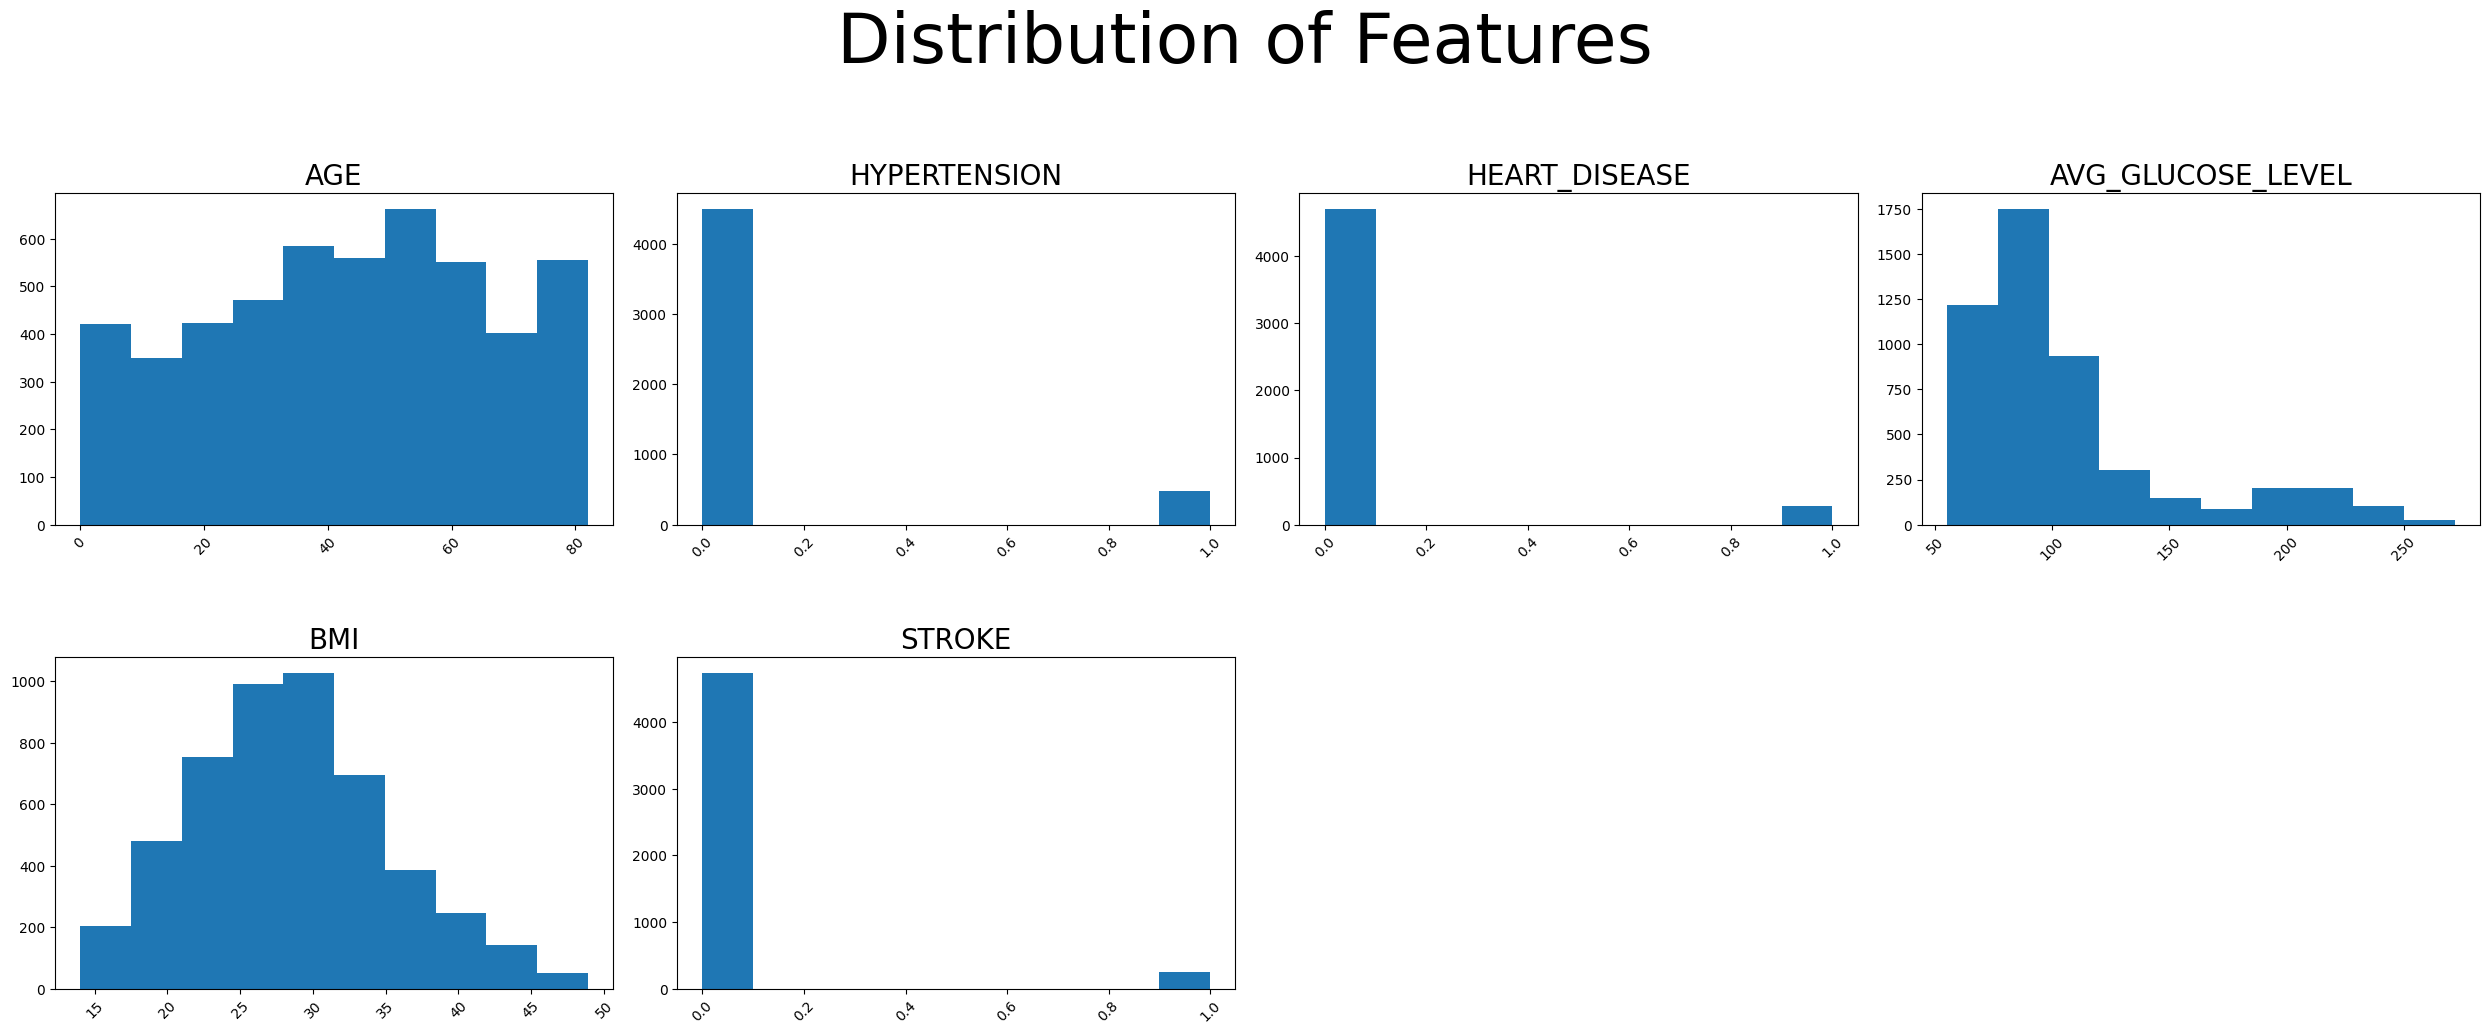

In [12]:
fig = plt.figure(figsize=(25,15)) ## Plot Size
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])

    plt.grid(False)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [13]:
df.corr('bmi','stroke')

0.05692566277908676

In [14]:
df.corr('hypertension','stroke')

0.13196524198200293

In [15]:
df.corr('heart_disease','stroke')

0.13461030532204826

In [16]:
df.corr('age','stroke')

0.2464778740312734

In [17]:
df.corr('avg_glucose_level','stroke')

0.1332273266331388

## Using Spark SQL

In [18]:
df.columns

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [19]:
# create DataFrame as a temporary view
df.createOrReplaceTempView('brain_stroke_T')

In [20]:
#group by gender
spark.sql(\
          "SELECT \
           gender, count(gender) as count_gender, \
           count(gender)*100/sum(count(gender)) over() as percent  \
           FROM brain_stroke_T GROUP BY gender" \
           ).show()

+------+------------+----------------+
|gender|count_gender|         percent|
+------+------------+----------------+
|Female|        2907|58.3617747440273|
|  Male|        2074|41.6382252559727|
+------+------------+----------------+



In [21]:
#group by gender having brain stroke
spark.sql(\
          "SELECT gender, count(gender), \
          round((COUNT(gender) * 100.0) /(SELECT count(gender) FROM brain_stroke_T ),2) as percentage \
          FROM brain_stroke_T WHERE stroke = '1'  GROUP BY gender"\
          ).show()

+------+-------------+----------+
|gender|count(gender)|percentage|
+------+-------------+----------+
|Female|          140|      2.81|
|  Male|          108|      2.17|
+------+-------------+----------+



In [22]:
#group by gender having heart disease
spark.sql(\
          "SELECT gender, count(gender), \
          round((COUNT(gender) * 100.0) /(SELECT count(gender) FROM brain_stroke_T ),2) as percentage \
          FROM brain_stroke_T WHERE heart_disease = '1'  GROUP BY gender"\
          ).show()

+------+-------------+----------+
|gender|count(gender)|percentage|
+------+-------------+----------+
|Female|          112|      2.25|
|  Male|          163|      3.27|
+------+-------------+----------+



In [23]:
#group by gender having hypertension
spark.sql(\
          "SELECT gender, count(gender), \
          round((COUNT(gender) * 100.0) /(SELECT count(gender) FROM brain_stroke_T ),2) as percentage \
          FROM brain_stroke_T WHERE hypertension = '1'  GROUP BY gender"\
          ).show()

+------+-------------+----------+
|gender|count(gender)|percentage|
+------+-------------+----------+
|Female|          264|      5.30|
|  Male|          215|      4.32|
+------+-------------+----------+



In [24]:
#count of different types of smoker
df.groupBy('smoking_status').count().show()

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|  776|
|        Unknown| 1500|
|   never smoked| 1838|
|formerly smoked|  867|
+---------------+-----+



In [25]:
#group by smoking_status having hypertension
spark.sql(\
          "SELECT smoking_status, count(smoking_status) as count, \
          round((COUNT(smoking_status) * 100.0) /(SELECT count(smoking_status) FROM brain_stroke_T ),2) as percentage \
          FROM brain_stroke_T   GROUP BY smoking_status"\
          ).show()

+---------------+-----+----------+
| smoking_status|count|percentage|
+---------------+-----+----------+
|         smokes|  776|     15.58|
|        Unknown| 1500|     30.11|
|   never smoked| 1838|     36.90|
|formerly smoked|  867|     17.41|
+---------------+-----+----------+



In [26]:
#Age vs stroke
spark.sql("SELECT age, count(age) as age_count FROM brain_stroke_T WHERE stroke == 1 GROUP BY age ORDER BY age_count DESC").show()

+----+---------+
| age|age_count|
+----+---------+
|78.0|       21|
|80.0|       17|
|79.0|       17|
|81.0|       14|
|57.0|       11|
|76.0|       10|
|63.0|        9|
|82.0|        9|
|74.0|        9|
|68.0|        9|
|77.0|        8|
|59.0|        8|
|71.0|        7|
|58.0|        7|
|70.0|        6|
|69.0|        6|
|75.0|        6|
|72.0|        6|
|61.0|        6|
|54.0|        6|
+----+---------+
only showing top 20 rows



In [27]:
#count of brain stroke patients over age 50
df.filter((df['stroke'] == 1) & (df['age'] > '50')).count()


226

## Data Preprocessing

In [28]:
#checking null values
df.toPandas().isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [29]:
df.dtypes

[('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'double'),
 ('smoking_status', 'string'),
 ('stroke', 'int')]

In [30]:
df.show()

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

# Serial Data Conversions

## String Indexer

In [31]:
genderIndexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
ever_marriedIndexer = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
work_typeIndexer = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
Residence_typeIndexer = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
smoking_statusIndexer = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")

In [32]:
genderIndexer.fit(df).transform(df).show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|genderIndex|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|        1.0|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|        1.0|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|        0.0|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|        0.0|
|  Male|81.0|

In [33]:
ever_marriedIndexer.fit(df).transform(df).show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|ever_marriedIndex|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|              0.0|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|              0.0|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|              0.0|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smok

In [34]:
work_typeIndexer.fit(df).transform(df).show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+--------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|work_typeIndex|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+--------------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|           0.0|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|           0.0|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|           0.0|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|        

In [35]:
Residence_typeIndexer.fit(df).transform(df).show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-------------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Residence_typeIndex|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-------------------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|                0.0|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|                1.0|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|                0.0|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0| 

In [36]:
smoking_statusIndexer.fit(df).transform(df).show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-------------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|smoking_statusIndex|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-------------------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|                2.0|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|                0.0|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|                3.0|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0| 

##One Hot Encoder

In [37]:
OHE_gender = OneHotEncoder(inputCols=["genderIndex"], outputCols=["genderVec"])
OHE_ever_married = OneHotEncoder(inputCols=["ever_marriedIndex"], outputCols=["ever_marriedVec"])
OHE_work_type = OneHotEncoder(inputCols=["work_typeIndex"], outputCols=["work_typeVec"])
OHE_Residence_type = OneHotEncoder(inputCols=["Residence_typeIndex"], outputCols=["Residence_typeVec"])
OHE_smoking_status = OneHotEncoder(inputCols=["smoking_statusIndex"], outputCols=["smoking_statusVec"])

In [38]:
OHE_gender.fit(genderIndexer.fit(df).transform(df)).transform(genderIndexer.fit(df).transform(df)).show(3)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-----------+-------------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|genderIndex|    genderVec|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-----------+-------------+
|  Male|67.0|           0|            1|         Yes|  Private|         Urban|           228.69|36.6|formerly smoked|     1|        1.0|    (1,[],[])|
|  Male|80.0|           0|            1|         Yes|  Private|         Rural|           105.92|32.5|   never smoked|     1|        1.0|    (1,[],[])|
|Female|49.0|           0|            0|         Yes|  Private|         Urban|           171.23|34.4|         smokes|     1|        0.0|(1,[0],[1.0])|
+------+----+------------+-------------+------------+---------+--------------+----------------

In [39]:
OHE_ever_married.fit(ever_marriedIndexer.fit(df).transform(df)).transform(ever_marriedIndexer.fit(df).transform(df)).show(3)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-----------------+---------------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|ever_marriedIndex|ever_marriedVec|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-----------------+---------------+
|  Male|67.0|           0|            1|         Yes|  Private|         Urban|           228.69|36.6|formerly smoked|     1|              0.0|  (1,[0],[1.0])|
|  Male|80.0|           0|            1|         Yes|  Private|         Rural|           105.92|32.5|   never smoked|     1|              0.0|  (1,[0],[1.0])|
|Female|49.0|           0|            0|         Yes|  Private|         Urban|           171.23|34.4|         smokes|     1|              0.0|  (1,[0],[1.0])|
+------+----+------------+-------------+------

In [40]:
OHE_work_type.fit(work_typeIndexer.fit(df).transform(df)).transform(work_typeIndexer.fit(df).transform(df)).show(3)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+--------------+-------------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|work_typeIndex| work_typeVec|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+--------------+-------------+
|  Male|67.0|           0|            1|         Yes|  Private|         Urban|           228.69|36.6|formerly smoked|     1|           0.0|(3,[0],[1.0])|
|  Male|80.0|           0|            1|         Yes|  Private|         Rural|           105.92|32.5|   never smoked|     1|           0.0|(3,[0],[1.0])|
|Female|49.0|           0|            0|         Yes|  Private|         Urban|           171.23|34.4|         smokes|     1|           0.0|(3,[0],[1.0])|
+------+----+------------+-------------+------------+---------+-------------

In [41]:
OHE_Residence_type.fit(Residence_typeIndexer.fit(df).transform(df)).transform(Residence_typeIndexer.fit(df).transform(df)).show(3)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-------------------+-----------------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Residence_typeIndex|Residence_typeVec|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-------------------+-----------------+
|  Male|67.0|           0|            1|         Yes|  Private|         Urban|           228.69|36.6|formerly smoked|     1|                0.0|    (1,[0],[1.0])|
|  Male|80.0|           0|            1|         Yes|  Private|         Rural|           105.92|32.5|   never smoked|     1|                1.0|        (1,[],[])|
|Female|49.0|           0|            0|         Yes|  Private|         Urban|           171.23|34.4|         smokes|     1|                0.0|    (1,[0],[1.0])|
+------+----+---------

In [42]:
OHE_smoking_status.fit(smoking_statusIndexer.fit(df).transform(df)).transform(smoking_statusIndexer.fit(df).transform(df)).show(3)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-------------------+-----------------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|smoking_statusIndex|smoking_statusVec|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-------------------+-----------------+
|  Male|67.0|           0|            1|         Yes|  Private|         Urban|           228.69|36.6|formerly smoked|     1|                2.0|    (3,[2],[1.0])|
|  Male|80.0|           0|            1|         Yes|  Private|         Rural|           105.92|32.5|   never smoked|     1|                0.0|    (3,[0],[1.0])|
|Female|49.0|           0|            0|         Yes|  Private|         Urban|           171.23|34.4|         smokes|     1|                3.0|        (3,[],[])|
+------+----+---------

##Assembler

In [43]:
df.columns

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [44]:
df.show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

In [45]:
F_assembler = VectorAssembler(inputCols=['genderVec', 'age', 'hypertension', 'heart_disease', 'bmi', 'smoking_statusVec', 'ever_marriedVec', 'Residence_typeVec', 'avg_glucose_level'],outputCol='X')

#Train - Test Split

In [46]:
train_df,test_df = df.randomSplit([0.7,0.3])
print(train_df.count())
print(test_df.count())

3470
1511


In [47]:
train_df.show(5)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|Female|0.08|           0|            0|          No| children|         Urban|           139.67|14.1|       Unknown|     0|
|Female| 0.4|           0|            0|          No| children|         Rural|            85.65|17.4|       Unknown|     0|
|Female|0.48|           0|            0|          No| children|         Rural|            94.06|14.8|       Unknown|     0|
|Female|0.56|           0|            0|          No| children|         Urban|            80.92|18.3|       Unknown|     0|
|Female|0.64|           0|            0|          No| children|         Urban|            83.82|24.9|       Unknown|     0|
+------+

In [48]:
test_df.show(5)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|Female|0.32|           0|            0|          No| children|         Rural|            55.86|16.0|       Unknown|     0|
|Female|0.32|           0|            0|          No| children|         Rural|            73.71|16.2|       Unknown|     0|
|Female|0.32|           0|            0|          No| children|         Urban|           108.63|19.6|       Unknown|     0|
|Female|0.48|           0|            0|          No| children|         Rural|           118.75|17.4|       Unknown|     0|
|Female|0.64|           0|            0|          No| children|         Urban|            62.27|17.3|       Unknown|     0|
+------+

In [49]:
basePipe = Pipeline(stages=[genderIndexer,ever_marriedIndexer,work_typeIndexer,Residence_typeIndexer,smoking_statusIndexer,OHE_gender,OHE_ever_married,
                            OHE_work_type,OHE_Residence_type,OHE_smoking_status,F_assembler])
basePipe.fit(df).transform(df).show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+-----------------+--------------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|genderIndex|ever_marriedIndex|work_typeIndex|Residence_typeIndex|smoking_statusIndex|    genderVec|ever_marriedVec| work_typeVec|Residence_typeVec|smoking_statusVec|                   X|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+-----------------+--------------------+
|  Male|67.0|           0|            1|         Yes|  

In [50]:
def model(model):
  model_pipeline = Pipeline(stages=[basePipe,model])
  model = model_pipeline.fit(train_df)
  model_predictions=model.transform(test_df)
  model_predictions.show(5)
  acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
  evaluator = BinaryClassificationEvaluator(labelCol='stroke')
  model_acc=acc_evaluator.evaluate(model_predictions)
  print(round(model_acc,3), 'is the accuray of the model pipeline')
  model_auroc = evaluator.evaluate(model_predictions, {evaluator.metricName: "areaUnderROC"})
  print("Area under ROC Curve: {:.4f}".format(model_auroc))


#Logistic Regression

In [51]:
lr = LogisticRegression(labelCol='stroke',featuresCol='X',maxIter=5)
model(lr)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|genderIndex|ever_marriedIndex|work_typeIndex|Residence_typeIndex|smoking_statusIndex|    genderVec|ever_marriedVec| work_typeVec|Residence_typeVec|smoking_statusVec|                   X|       rawPrediction|         probability|prediction|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+----

#Decision Tree Classifier

In [52]:
dt = DecisionTreeClassifier(labelCol='stroke',featuresCol='X')
model(dt)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+-----------------+--------------------+-------------+--------------------+----------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|genderIndex|ever_marriedIndex|work_typeIndex|Residence_typeIndex|smoking_statusIndex|    genderVec|ever_marriedVec| work_typeVec|Residence_typeVec|smoking_statusVec|                   X|rawPrediction|         probability|prediction|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+-----------------+

#Random Forest

In [53]:
rf = RandomForestClassifier(labelCol = 'stroke',featuresCol = 'X')
model(rf)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|genderIndex|ever_marriedIndex|work_typeIndex|Residence_typeIndex|smoking_statusIndex|    genderVec|ever_marriedVec| work_typeVec|Residence_typeVec|smoking_statusVec|                   X|       rawPrediction|         probability|prediction|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+----

#Naive Bayes

In [54]:
nb=NaiveBayes(labelCol='stroke',featuresCol='X')
model(nb)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|genderIndex|ever_marriedIndex|work_typeIndex|Residence_typeIndex|smoking_statusIndex|    genderVec|ever_marriedVec| work_typeVec|Residence_typeVec|smoking_statusVec|                   X|       rawPrediction|         probability|prediction|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+-------------------+-------------+---------------+-------------+-----------------+----

### CONCLUSION: The best fit model is Random Forest with an accuracy of the pipeline 94.6% and Area under the curve is around 80.57%